In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create grid of points

# Define possible X and Y values
xvals = np.arange(0, 26)
yvals = np.arange(0, 22)

# creates matrices for X and Y combinations for grid of points
xx, yy = np.meshgrid(xvals, yvals)

In [3]:
# Estimating latitude longitude gridlines over the 4 states:
#    Utah, Colorado, Arizona, New Mexico
# Grid is varying longitude / latitude by half a degree. 
# Estimations:
#    27 mile width
#    34 mile length
xx = xx * 27
yy = yy * 34

In [4]:
# Create numpy array of points (combining X and Y combinations)
points = np.array([xx, yy])

# Reshape it so 2 columns (X column and Y column)
points = np.reshape(np.reshape(points, 22*26*2, order = 'F'), [22*26, 2])

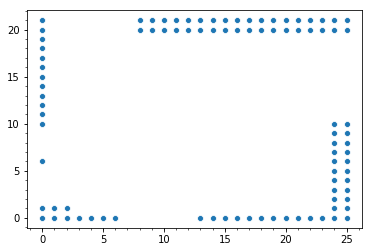

In [6]:
# Delete points that are not in states.

# First column delPoints
delPoints = list(range(2)) + list(range(6, 7)) + list(range(10,22))
# 2nd / 3rd column delPoints
delPoints = delPoints + [x+22 for x in list(range(2))]
delPoints = delPoints + [x+44 for x in list(range(2))]
# 4th through 7th column delPoints
delPoints = delPoints + [x*22 for x in list(range(3, 7))]
# Highest row past tip of Utah
delPoints = delPoints + [x*22 + 21 for x in range(8, 26)]
# 2nd highest row past tip of Utah
delPoints = delPoints + [x*22 + 20 for x in range(8, 26)] 
# Rest of bottom row
delPoints = delPoints + [x*22 for x in range(13, 26)]
# Second to last column
delPoints = delPoints + [24*22 + x for x in range(1, 11)]  
# Last column
delPoints = delPoints + [25*22 + x for x in range(1, 11)]  

# print(delPoints)  # print row indexes of points you are deleting

# Plot points you are deleting
# Create plot, scaled back down
ax = sns.scatterplot(points[delPoints,0] / 27, y=points[delPoints,1] / 34) 
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor y tics
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor x tics
ax   # Display plot

In [ ]:
# Deleting points in delPoints.
points = np.delete(points, delPoints, axis=0)

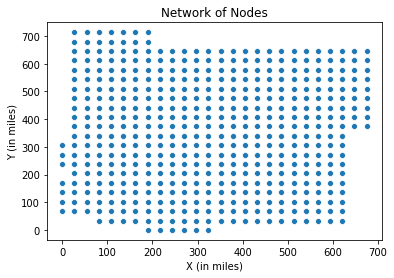

In [12]:
# Plot remaining points
ax = sns.scatterplot(x=points[:,0], y=points[:,1])
ax.set(xlabel='X (in miles)', ylabel='Y (in miles)', title = 'Network of Nodes')
#ax.figure.savefig("nodeGrid.png")  # Saving the figure
ax

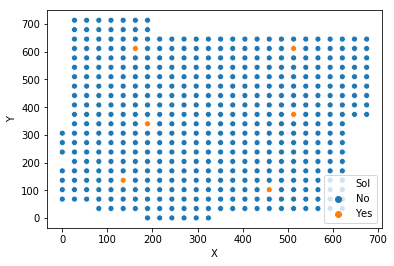

In [7]:
# Plotting solution when DC = 200
# Must minus one from AMPL solution (index starts at 0 vs 1)
XSol200 = [92, 127, 141, 384, 331, 377]  # REMEMBER TO MINUS ONE FROM AMPL SOL

# Make dataframe of points
pointsData = pd.DataFrame(points, columns = ['X','Y'])
# Add binary factor column for solution points
pointsData['Sol'] = 'No'
pointsData.iloc[XSol200, 2] = 'Yes'

# Create and display scatterplot
ax = sns.scatterplot(x='X', y='Y', hue='Sol', data = pointsData)
ax

In [9]:
# Create shortest path distance matrix
spd = np.zeros((480, 480))  # initialize with zeros
count1 = -1  # rowIndex
for p1 in points:
    count1 += 1
    count2 = 0   # columnIndex
    for p2 in points:
        dist = np.linalg.norm(p1 - p2) # Euclidean distance
        spd[count1, count2] = dist  # Add to spd matrix
        count2 += 1   # increase columnIndex

In [11]:
#np.savetxt('spd.txt', spd, fmt = '%.4f', delimiter = ' ')  # Save spd

In [12]:
# making F matrix
numNodes = spd.shape[0]  # number of points/nodes
rowIndex= -1

# initialize F matrix
F = np.zeros(( int(.5 * (numNodes * (numNodes - 1))), numNodes ))

for u in range(numNodes-1):
    for v in range(u+1, numNodes):  # u, v is pair of points
        rowIndex += 1
        for j in range(numNodes):  # j: Where may be locating 'sensor' (radar)
            if spd[u, j] != spd[v, j]:  # If resolving constraint satisfied
                F[rowIndex, j] = 1      # Set to 1
            else:
                F[rowIndex, j] = 0      # Resolving constraint not satisfied

In [13]:
# n is number of nodes
F.shape  # Check shape -> (n choose 2) rows, (n) columns

(114960, 480)

In [15]:
# Define row and column names to be indexes
# indexed by 1 to (n choose 2)
row_names = range(1, F.shape[0]+1)
# indexed by 1 to n
col_names = range(1, numNodes + 1)
FData = pd.DataFrame(F, columns = col_names, index = row_names)
#FData.to_csv('FDataFrameNums.txt', sep = ' ')  # Save F matrix